# Generate music with an RNN

Find the datasets in the url below👇

https://magenta.tensorflow.org/datasets/maestro

  First of all, Install [`pretty_midi`](https://github.com/craffel/pretty-midi) library to create and parse MIDI files, and [`pyfluidsynth`](https://github.com/nwhitehead/pyfluidsynth) for generating audio playback in Colab.

In [1]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install pretty_midi

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

In [2]:
# Import necessary libraries for the script
import collections  # Used for specialized data structures like dictionaries
import datetime  # Used for working with dates and times
import fluidsynth  # Used for synthesizing audio from MIDI data
import glob  # Used for finding files matching a pattern (e.g., MIDI files)
import numpy as np  # Fundamental library for numerical computing in Python (arrays, matrices)
import pathlib  # Used for managing file and directory locations
import pandas as pd  # Used for data manipulation and analysis, especially with tabular data
import pretty_midi  # Core library for handling MIDI data in this script
import seaborn as sns  # Used for creating statistical visualizations
import tensorflow as tf  # Powerful library for machine learning and neural networks

# Import specific elements from libraries
from IPython import display  # Used for displaying rich content in Jupyter notebooks
from matplotlib import pyplot as plt  # Used for creating plots and visualizations
from typing import Optional  # Used for specifying optional function arguments

In [3]:
seed = 42  # Define a seed value for reproducibility
tf.random.set_seed(seed)  # Set the random seed for TensorFlow
np.random.seed(seed)  # Set the random seed for NumPy

# Sampling rate for audio playback (samples per second)
_SAMPLING_RATE = 16000

## Download the datasets

In [5]:
data_dir = pathlib.Path('data/maestro-v2_extracted/maestro-v2.0.0')  # creates a pathlib object representing the directory where the maestro dataset will be stored
if not data_dir.exists():  # checks if the data directory already exists
  tf.keras.utils.get_file( # downloads the maestro dataset if it doesn't exist in the data directory
      'maestro-v2.0.0-midi.zip',  # specifies the filename for the downloaded zip file
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',  # provides the url from where the dataset will be downloaded
      extract=True,  # automatically extracts the downloaded zip file
      cache_dir='.', cache_subdir='data',  # specifies the directory where the downloaded file will be cached
  )

The dataset contains about 1,200 MIDI files.

In [6]:
 # retrieves all midi files from the specified data directory and its subdirectories
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


## Process a MIDI file

First, use ```pretty_midi``` to parse a single MIDI file and inspect the format of the notes. If you would like to download the MIDI file below to play on your computer, you can do so in colab by writing ```files.download(sample_file)```.


In [7]:
sample_file = filenames[1] if filenames else []
print(sample_file)

data/maestro-v2_extracted/maestro-v2.0.0/2004/MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav.midi


Generate a `PrettyMIDI` object for the sample MIDI file.

In [8]:
pm = pretty_midi.PrettyMIDI(sample_file)

Play the sample file. The playback widget may take several seconds to load.

In [9]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  """plays the audio of the midi file for specified number of seconds.
  args:
    pm: pretty_midi.PrettyMIDI object representing the midi file.
    seconds: number of seconds to play, defaults to 30 seconds.
  returns:
    an IPython.display.Audio object for playing the audio.
  """
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)  # generates waveform audio data from the midi using fluidsynth at the specified sample rate
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE] # takes a slice of the waveform for the given duration
  return display.Audio(waveform_short, rate=_SAMPLING_RATE) # creates and returns an audio object for playback in the notebook


In [10]:
display_audio(pm)

### You can download the audio file just by excuting the cell below

In [11]:
# import pretty_midi
from google.colab import files

# Assuming 'sample_file' is defined as in the original code (filenames[1])
# If not, replace with the actual path to your MIDI file

pm = pretty_midi.PrettyMIDI(sample_file)

# Download the MIDI file
files.download(sample_file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Do some inspection on the MIDI file. What kinds of instruments are used?

In [12]:
print('Number of instruments:', len(pm.instruments)) # prints the total number of instruments in the midi file using len() on the instruments list from the PrettyMIDI object
instrument = pm.instruments[0] # gets the first instrument from the list of instruments in the PrettyMIDI object
instrument_name = pretty_midi.program_to_instrument_name(instrument.program) # gets the name of the instrument using its program number
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


## Extract notes

In [13]:
# iterates through the first 10 notes of the instrument
for i, note in enumerate(instrument.notes[:10]):
  # gets the name of the note using pretty_midi's note_number_to_name function
  note_name = pretty_midi.note_number_to_name(note.pitch)
  # calculates the duration of the note by subtracting the start time from the end time
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=31, note_name=G1, duration=0.0656
1: pitch=43, note_name=G2, duration=0.0792
2: pitch=44, note_name=G#2, duration=0.0740
3: pitch=32, note_name=G#1, duration=0.0729
4: pitch=34, note_name=A#1, duration=0.0708
5: pitch=46, note_name=A#2, duration=0.0948
6: pitch=48, note_name=C3, duration=0.6260
7: pitch=36, note_name=C2, duration=0.6542
8: pitch=53, note_name=F3, duration=1.7667
9: pitch=56, note_name=G#3, duration=1.7688


You will use three variables to represent a note when training the model: `pitch`, `step` and `duration`. The pitch is the perceptual quality of the sound as a MIDI note number.
The `step` is the time elapsed from the previous note or start of the track.
The `duration` is how long the note will be playing in seconds and is the difference between the note end and note start times.


Extract the notes from the sample MIDI file.

In [14]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [17]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head() # show the first 5 row data

,pitch,start,end,step,duration
0,43,1.032292,1.111458,0.000000,0.079167
1,31,1.040625,1.106250,0.008333,0.065625
2,44,1.142708,1.216667,0.102083,0.073958
3,32,1.144792,1.217708,0.002083,0.072917
4,46,1.208333,1.303125,0.063542,0.094792


- N.B: This show that the piches are not being repeated, so we will get collections of diffrent sounds

It may be easier to interpret the note names rather than the pitches, so you can use the function below to convert from the numeric pitch values to note names.
The note name shows the type of note, accidental and octave number
(e.g. C#4).

In [18]:
# vectorizes the pretty_midi.note_number_to_name function for efficient application to arrays
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
# applies the vectorized function to get note names from the 'pitch' column of raw_notes DataFrame
sample_note_names = get_note_names(raw_notes['pitch'])
# displays the first 10 note names in the sample_note_names array
sample_note_names[:10]

array(['G2', 'G1', 'G#2', 'G#1', 'A#2', 'A#1', 'C3', 'C2', 'F3', 'D4'],
      dtype='<U3')

To visualize the musical piece, plot the note pitch, start and end across the length of the track (i.e. piano roll). Start with the first 100 notes

In [19]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

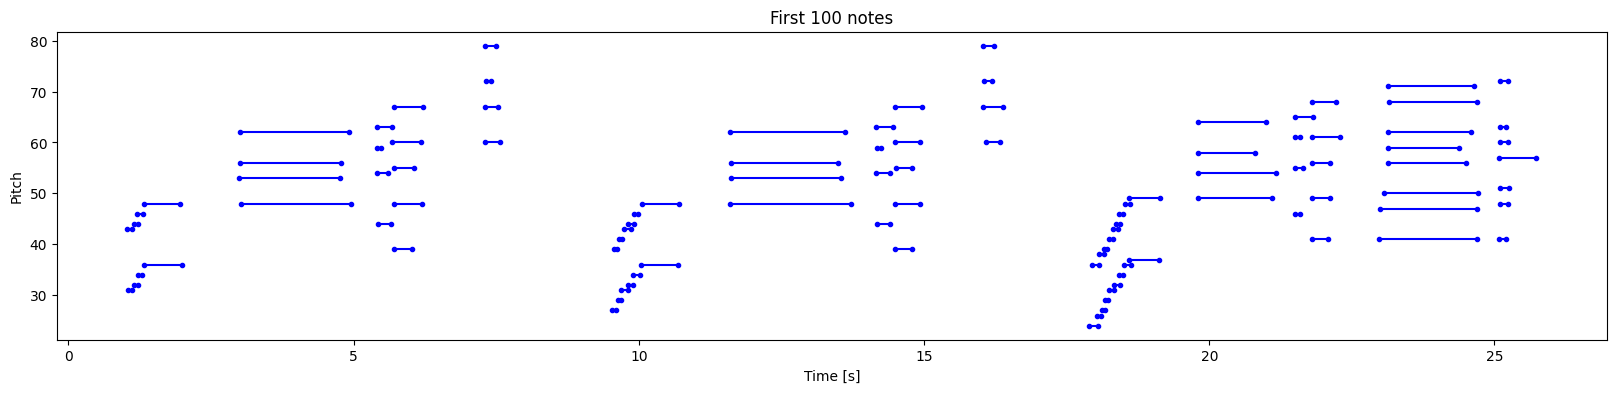

In [ ]:
plot_piano_roll(raw_notes, count=100)

Plot the notes for the entire track.

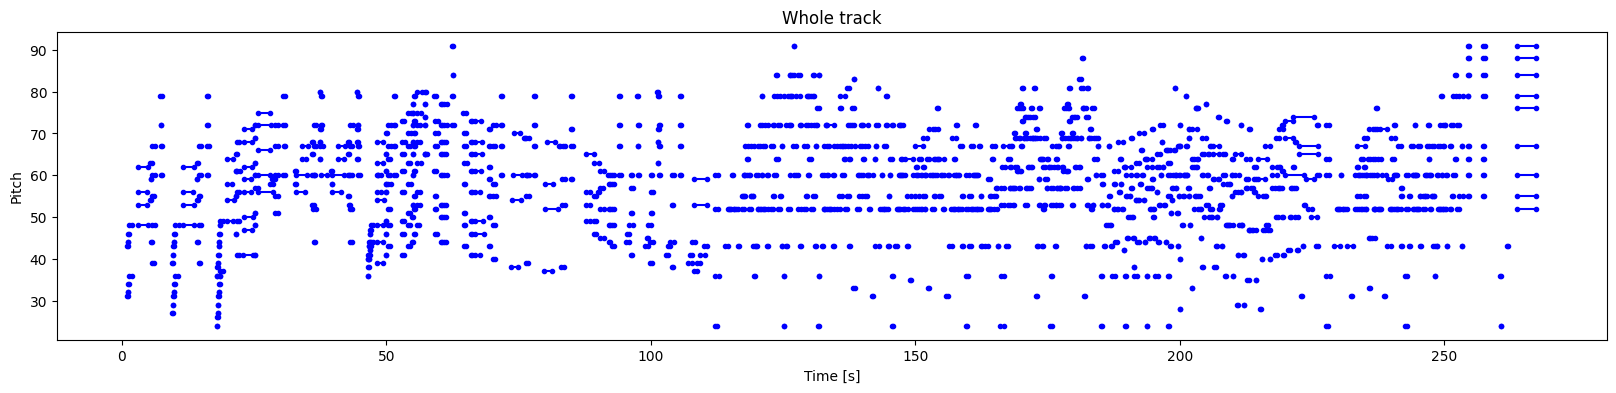

In [ ]:
plot_piano_roll(raw_notes)

Check the distribution of each note variable.

In [ ]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

In [ ]:
plot_distributions(raw_notes)

## Create a MIDI file

You can generate your own MIDI file from a list of notes using the function below.

In [ ]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [ ]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

Play the generated MIDI file and see if there is any difference.

In [ ]:
display_audio(example_pm)

In [ ]:
#write a code to download the example_pm midi file

import pathlib
import pretty_midi

# Assuming 'example.midi' is in the current directory or a known location
# Replace with the actual path if needed

example_file = 'example.midi'  # Or the path to your example.midi file

try:
  example_pm = pretty_midi.PrettyMIDI(example_file)
  print(f"Successfully loaded {example_file}")
except FileNotFoundError:
  print(f"Error: {example_file} not found.  Make sure it exists in the current directory.")
except Exception as e:
  print(f"An error occurred: {e}")


Successfully loaded example.midi


As before, you can write ```files.download(example_file)``` to download and play this file.

## Create the training dataset


Create the training dataset by extracting notes from the MIDI files. You can start by using a small number of files, and experiment later with more. This may take a couple minutes.

In [ ]:
num_files = 5  # sets the number of midi files to process.
all_notes = []  # initializes an empty list to store all extracted notes.

# iterates through the first 'num_files' midi files in the 'filenames' list.
for f in filenames[:num_files]:
  notes = midi_to_notes(f)  # extracts notes from the current midi file using the 'midi_to_notes' function.
  all_notes.append(notes)  # appends the extracted notes to the 'all_notes' list.

# concatenates all the dataframes in 'all_notes' into a single dataframe.
all_notes = pd.concat(all_notes)

In [ ]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 16785


Next, create a `tf.data.Dataset` from the parsed notes.

In [ ]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [ ]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

You will train the model on batches of sequences of notes. Each example will consist of a sequence of notes as the input features, and the next note as the label.


In [ ]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

Set the sequence length for each example. Experiment with different lengths (e.g. 50, 100, 150) to see which one works best for the data, or use [hyperparameter tuning](https://www.tensorflow.org/tutorials/keras/keras_tuner). The size of the vocabulary (`vocab_size`) is set to 128 representing all the pitches supported by `pretty_midi`.

In [ ]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

The shape of the dataset is ```(100,1)```, meaning that the model will take 100 notes as input, and learn to predict the following note as output.

In [ ]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.4453125  0.         0.19791667]
 [0.453125   0.16145833 0.125     ]
 [0.40625    0.121875   0.1375    ]
 [0.4765625  0.11979167 0.14583333]
 [0.5        0.13333333 0.17708333]
 [0.3515625  0.02291667 0.27083333]
 [0.2578125  0.00208333 0.24479167]
 [0.4296875  0.13229167 0.09791667]
 [0.4453125  0.10104167 0.08541667]
 [0.453125   0.08854167 0.06354167]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=63.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.09791666666666643>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.054166666666666696>}


Batch the examples, and configure the dataset for performance.

In [ ]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Create and train the model

The model will have three outputs, one for each note variable. For `step` and `duration`, you will use a custom loss function based on mean squared error that encourages the model to output non-negative values.

In [ ]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [ ]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 25, 3)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 128)            │         67,584 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ duration (Dense)          │ (None, 1)              │            129 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pitch (Dense)             │ (None, 128)            │         16,512 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ step (Dense)              │ (None, 1)              │            129 │ lstm[0][0]             │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 84,354 (329.51 KB)

 Trainable params: 84,354 (329.51 KB)

 Non-trainable params: 0 (0.00 B)

Testing the `model.evaluate` function, you can see that the `pitch` loss is significantly greater than the `step` and `duration` losses.
Note that `loss` is the total loss computed by summing all the other losses and is currently dominated by the `pitch` loss.

In [ ]:
losses = model.evaluate(train_ds, return_dict=True)
losses

261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - duration_loss: 0.8276 - loss: 5.7473 - pitch_loss: 4.8538 - step_loss: 0.0659


{'duration_loss': 0.8224376440048218,
 'loss': 5.717554092407227,
 'pitch_loss': 4.835127353668213,
 'step_loss': 0.05998656898736954}

One way balance this is to use the `loss_weights` argument to compile:

In [ ]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

The `loss` then becomes the weighted sum of the individual losses.

In [ ]:
model.evaluate(train_ds, return_dict=True)

261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - duration_loss: 0.8276 - loss: 1.1362 - pitch_loss: 4.8538 - step_loss: 0.0659


{'duration_loss': 0.8224376440048218,
 'loss': 1.1241801977157593,
 'pitch_loss': 4.835127353668213,
 'step_loss': 0.05998656898736954}

Train the model.

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}.weights.h5',  # defines the file path for saving model weights.
        save_weights_only=True),  # indicates that only model weights should be saved.
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',  # specifies the metric to monitor for early stopping (loss in this case).
        patience=5,  # sets the number of epochs with no improvement before stopping.
        verbose=1,  # sets the verbosity level (1 for basic info).
        restore_best_weights=True),  # indicates that model weights from the best epoch should be restored.
]

In [ ]:
%%time
epochs = 15  # you can enlarge the epoch so that the model will tained very well

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - duration_loss: 0.0563 - loss: 0.2639 - pitch_loss: 3.5972 - step_loss: 0.0277
Epoch 2/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - duration_loss: 0.0573 - loss: 0.2670 - pitch_loss: 3.6165 - step_loss: 0.0289
Epoch 3/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - duration_loss: 0.0533 - loss: 0.2594 - pitch_loss: 3.5696 - step_loss: 0.0277
Epoch 4/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - duration_loss: 0.0524 - loss: 0.2566 - pitch_loss: 3.5582 - step_loss: 0.0263
Epoch 5/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - duration_loss: 0.0527 - loss: 0.2587 - pitch_loss: 3.5610 - step_loss: 0.0280
Epoch 6/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - duration_loss: 0.0499 - loss: 0.2519 - pitch_loss: 3.5398 - step_loss: 0.0250
Epoch 7/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - duration_loss: 0.0490 - loss: 0.2491 - pitch_loss: 3.5211 - step_loss: 0.0240
Epoch 8/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - duration_loss: 0.0498 

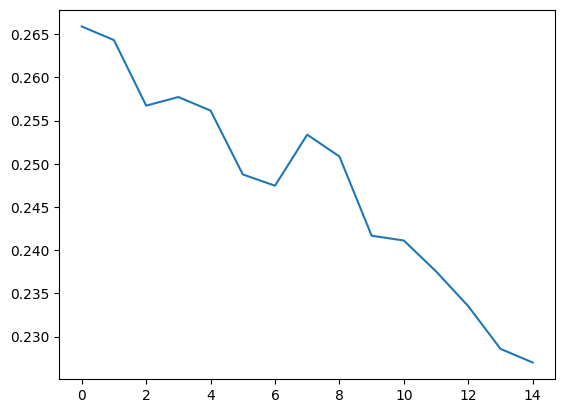

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## Generate notes

To use the model to generate notes, you will first need to provide a starting sequence of notes. The function below generates one note from a sequence of notes.

The `temperature` parameter can be used to control the randomness of notes generated. if you increase a lot, the more likely mistake it is gonna make

In [ ]:
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

Now generate some notes. You can play around with temperature and the starting sequence in `next_notes` and see what happens.

In [ ]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━

In [ ]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,47,1.709044,0.387741,1.709044,2.096786
1,72,0.117461,0.286686,1.826506,2.113191
2,79,0.159228,0.418389,1.985733,2.404122
3,84,0.154256,0.408471,2.139989,2.548460
4,74,0.153554,0.406692,2.293543,2.700235
5,73,0.154312,0.403594,2.447856,2.851450
6,50,0.154546,0.402782,2.602402,3.005184
7,74,0.154649,0.379247,2.757052,3.136299
8,84,0.154662,0.402501,2.911713,3.314214
9,84,0.154441,0.405015,3.066155,3.471169


In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

In [ ]:
# if you wanna download the output audio file, run this cell
from google.colab import files
files.download(out_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Let's visualize the generated notes.

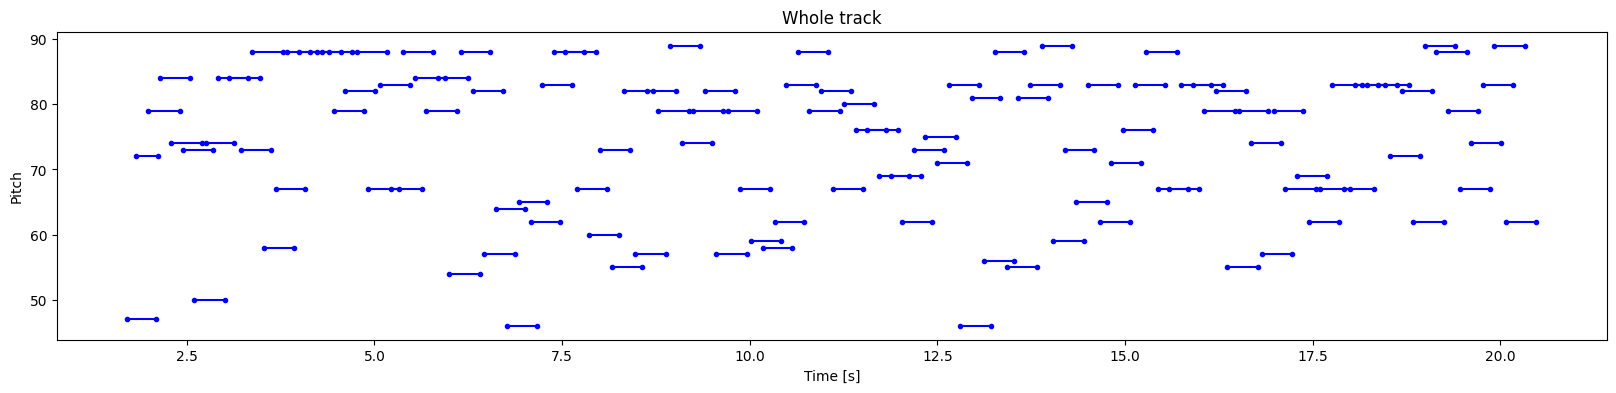

In [ ]:
plot_piano_roll(generated_notes)

Check the distributions of `pitch`, `step` and `duration`.

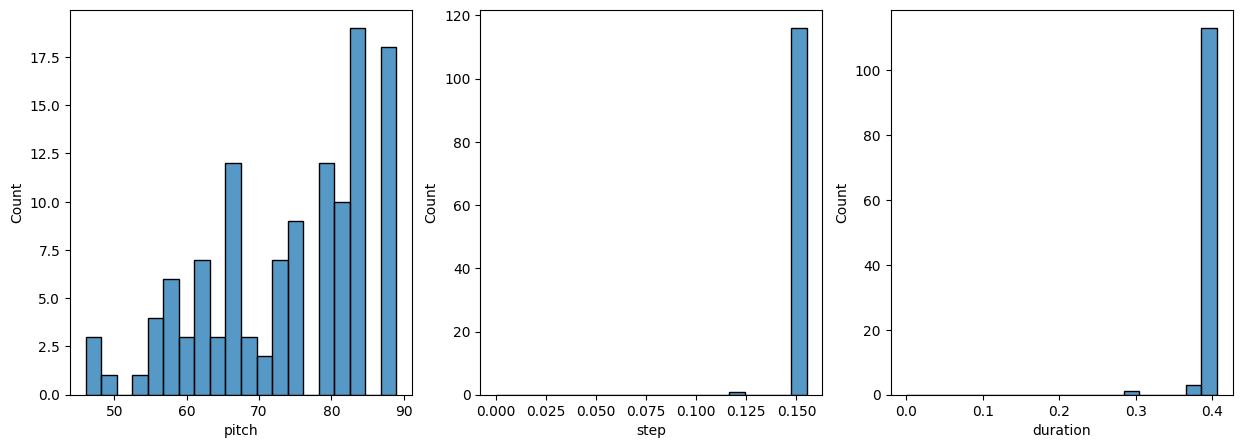

In [ ]:
plot_distributions(generated_notes)

Since there is a feedback loop between the model's outputs and inputs, the model tends to generate similar sequences of outputs to reduce the loss.
This is particularly relevant for `step` and `duration`, which uses the MSE loss.
For `pitch`, you can increase the randomness by increasing the `temperature` in `predict_next_note`.


# Huge Thanks to CodeAlpha! 🎉

I just wanted to take a moment to express my **heartfelt gratitude** to **CodeAlpha** for providing me with an incredible internship opportunity in the feild of `Artificial Intelligence`! 🙌✨

This experience has been nothing short of amazing, and I have learned so much! 📚💡  


I’m truly grateful for this opportunity! Here’s to more learning and growth ahead! 🚀🌟

**Thank you, CodeAlpha!** 💖🙌🎉
